In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from astropy.io import fits
from astropy.table import Table
from grizli import model as griz_model
from scipy.interpolate import interp1d
from spec_exam import Gen_spec
from spec_tools import Get_Sensitivity, Scale_model
import pysynphot as S
from time import time
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
metal=np.array([0.002, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03])
age=np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])

In [3]:
age_key = np.repeat('aaaaaaaaaaa',metal.size*age.size).reshape([metal.size,age.size])

for i in range(metal.size):
    for ii in range(age.size):
        age_key[i][ii] = 'm{0}_a{1}'.format(metal[i],age[ii])

In [4]:
wv=[]
fl=[]

for i in range(metal.size):
    for ii in range(age.size):
        wv, f = np.load(hpath + 'fsps_models_for_fit/fsps_spec/{0}_dt0_spec.npy'.format(age_key[i][ii]))
        fl.append(f)
        
wv = np.array(wv)
fl = np.array(fl)

In [5]:
IDX = [U for U in range(wv.size) if 2000 <= wv[U] <= 9500 ]

In [6]:
fl = [U[IDX] for U in fl]

In [7]:
wv = np.array(wv[IDX])
fl = np.array(fl)

In [9]:
spec_data = np.concatenate(([wv],fl),axis=0)

In [10]:
wv = spec_data[0]
fl = spec_data[1:]

In [22]:
np.array([8000,18000]) / 2 , np.array([8000,18000]) / 3 

(array([4000., 9000.]), array([2666.66666667, 6000.        ]))

4479


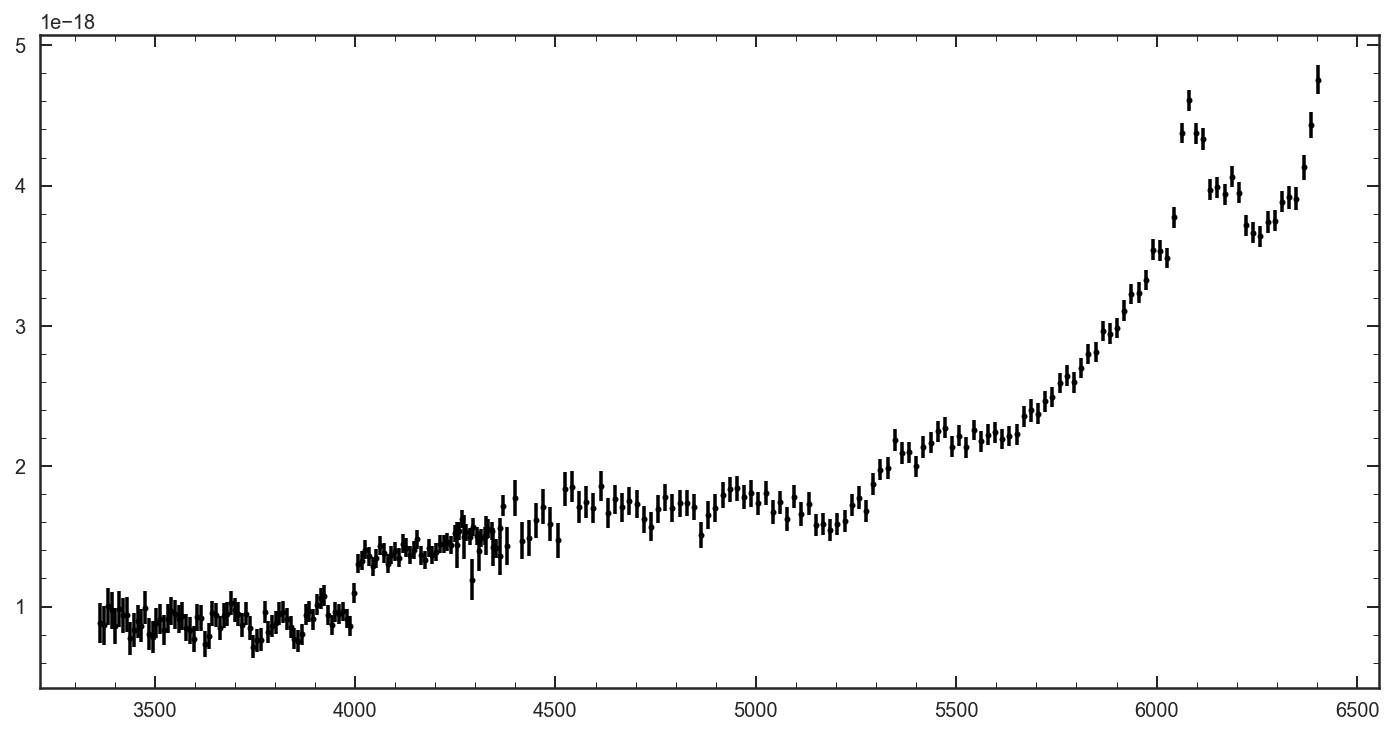

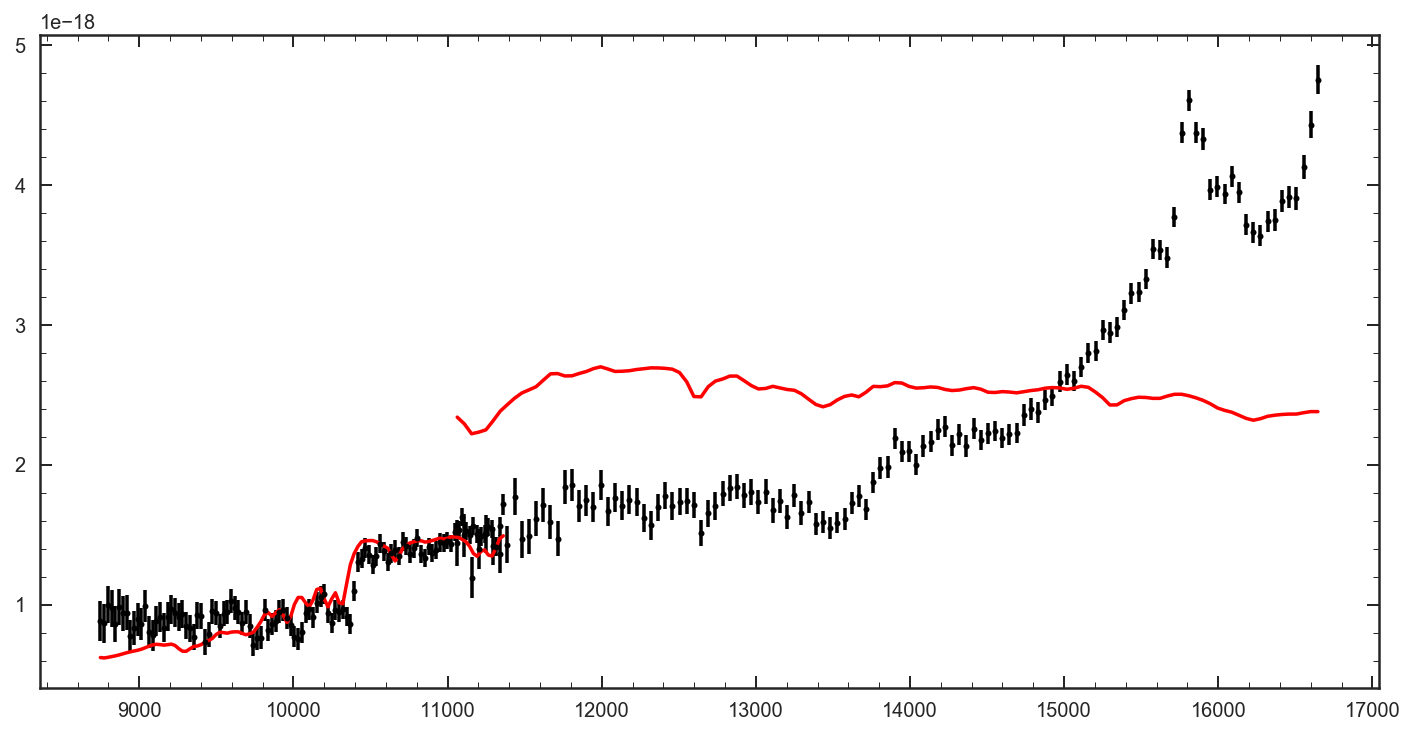

In [110]:
w, f = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.01_a1.5_dt0_spec.npy')
IDT = [U for U in range(w.size) if 2000 <= w[U] <= 10000 ]

print(len(IDT))

sp.Gen_sim(w[IDT],f[IDT],1.615)
plt.figure(figsize=[12,6])
plt.errorbar(sp.g102_wv/2.6,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='k')
plt.errorbar(sp.g141_wv/2.6,sp.g141_fl,sp.g141_er,linestyle='None', marker='o', markersize=3, color='k')
# plt.plot(sp.g102_wv,sp.g102_mfl,'r')
# plt.plot(sp.g141_wv,sp.g141_mfl,'r')


sp.Gen_sim(w[IDT],f[IDT],1.605)
plt.figure(figsize=[12,6])
plt.errorbar(sp.g102_wv,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='k')
plt.errorbar(sp.g141_wv,sp.g141_fl,sp.g141_er,linestyle='None', marker='o', markersize=3, color='k')
plt.plot(sp.g102_wv,sp.g102_mfl,'r')
plt.plot(sp.g141_wv,sp.g141_mfl,'r')

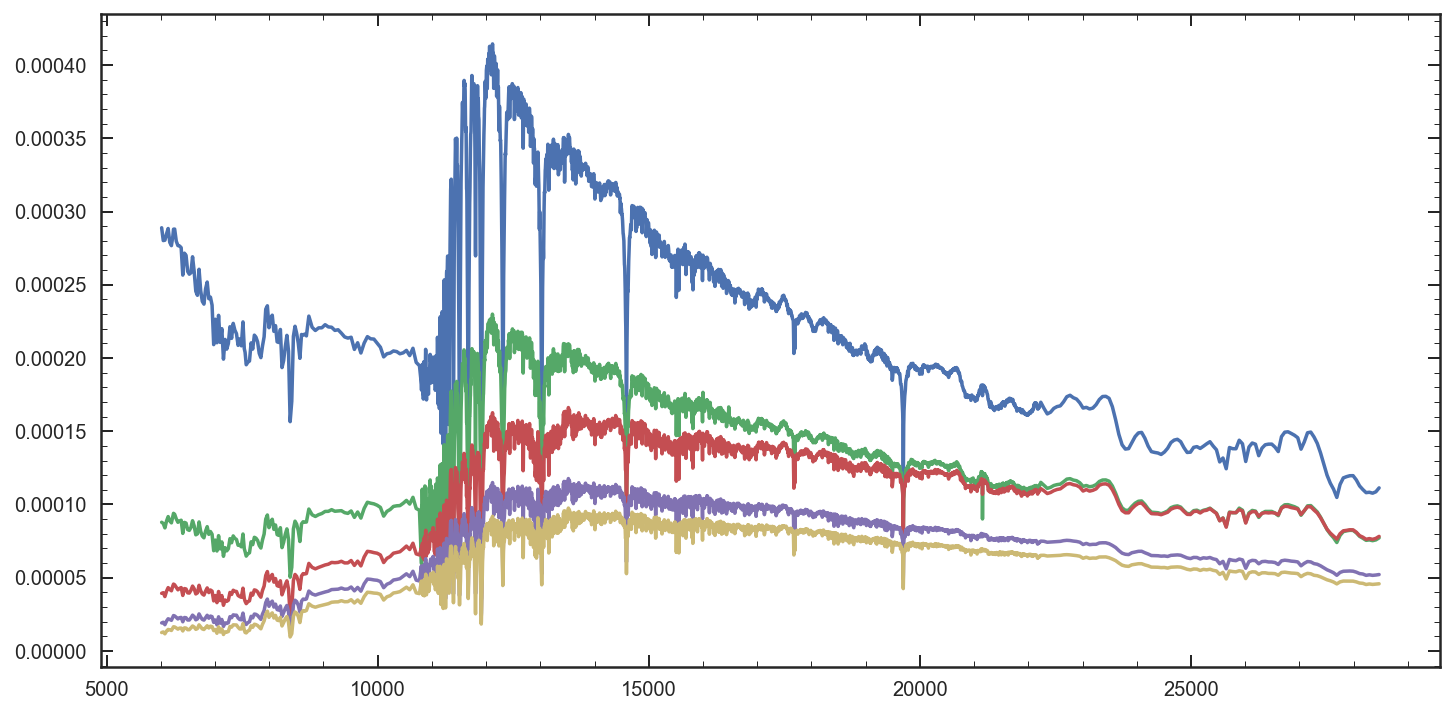

In [11]:
plt.figure(figsize=[12,6])
for i in range(5):
    plt.plot(wv*3,fl[i])

In [97]:
sp  = Gen_spec(42113,g102_max=11400,g141_min=11000)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_exam.py:226: RuntimeWarning: invalid value encountered in sqrt
  weight = np.exp(-(1*np.abs(BEAM.contam)*np.sqrt(ivar)))
/Users/vestrada/miniconda3/envs/astroco

In [79]:
z = np.arange(1.55,1.705,0.005)

In [103]:
g102_mfl = np.zeros([z.size*metal.size*age.size,sp.g102_wv.size])
g141_mfl = np.zeros([z.size*metal.size*age.size,sp.g141_wv.size])

for i in range(z.size):
    for ii in range(metal.size):
        for iii in range(age.size):
            sp.Gen_sim(wv,fl[ii*age.size + iii],z[i])
            g102_mfl[i*metal.size*age.size + ii*age.size + iii]=sp.g102_mfl
            g141_mfl[i*metal.size*age.size + ii*age.size + iii]=sp.g141_mfl

In [107]:
chi102 = chi_sq_gr(sp.g102_fl,sp.g102_er,g102_mfl) 
chi141 = chi_sq_gr(sp.g141_fl,sp.g141_er,g141_mfl)
chi = chi102 + chi141

In [44]:
def chi_sq_gr(data, error, model):
    return np.sum(((data - model) / error) ** 2, axis=1).reshape([z.size, metal.size, age.size]).astype(np.float128)

In [108]:
####### Create normalize probablity marginalized over tau
P102 = np.exp(-chi102.astype(np.float128) / 2)
P141 = np.exp(-chi141.astype(np.float128) / 2)
P = np.exp(-chi.astype(np.float128) / 2)

prob102 = np.trapz(P102, age, axis=2)
prob141 = np.trapz(P141, age, axis=2)
prob = np.trapz(P, age, axis=2)

C102 = np.trapz(np.trapz(prob102, metal, axis=1), z)
C141 = np.trapz(np.trapz(prob141, metal, axis=1), z)
C = np.trapz(np.trapz(prob, metal, axis=1), z)

prob102 /= C102
prob141 /= C141
prob /= C

#### Get Z and t posteriors

Pz102 = np.trapz(prob102, metal, axis=1)
Pz141 = np.trapz(prob141, metal, axis=1)
Pz = np.trapz(prob, metal, axis=1)


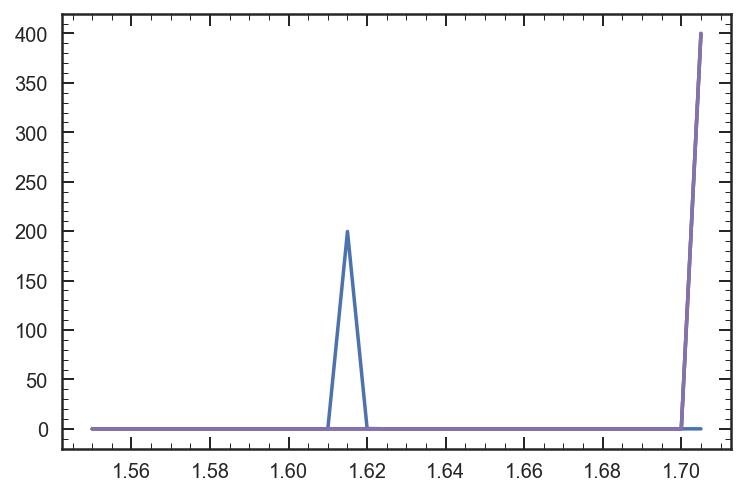

In [109]:
comb= Pz102*Pz141 / np.trapz(Pz102*Pz141,z)
plt.plot(z,Pz102)
plt.plot(z,Pz141)
plt.plot(z,Pz)
plt.plot(z,comb)


In [87]:
bfs = np.argwhere(chi102 == chi102.min())[0]
print(z[bfs[0]])
print(metal[bfs[1]])
print(age[bfs[2]])

1.6099999999999988
0.015
1.0


In [89]:
bfs = np.argwhere(chi141 == chi141.min())[0]
print(z[bfs[0]])
print(metal[bfs[1]])
print(age[bfs[2]])

1.6049999999999989
0.01
1.5
